## 라이브러리 로드

In [1]:
import os
import sys
import numpy as np # linear algebra
import subprocess
import matplotlib.pyplot as plt
from PIL import Image
import cv2
try:
    import dlib
except:
    subprocess.call([sys.executable, "-m", "pip", "install", "dlib"])

## Pre-trained 모델 로드

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('C:/kaggle/real_fake_face_detection/shape_predictor_68_face_landmarks.dat')

## 디렉터리 로드

In [22]:
fake_path = 'C:/kaggle/real_fake_face_detection/training_fake/'
real_path = 'C:/kaggle/real_fake_face_detection/training_real/'
fake_files = os.listdir(fake_path)
real_files = os.listdir(real_path)

## 파일이름 분할 및 fake 정보 추출 / real 파일 이름 추출

In [23]:
def get_real_fake_info(fake_files, real_files):
    fake_dict= dict()
    real_dict = dict()
    
    for fake_fname in fake_files:
        fake_info = fake_fname.split('.')[0].split('_')
        level = fake_info[0]
        file_num = fake_info[1]
        rgs = [int(x) for x in str(fake_info[2])]
        fake_dict[fake_fname]=[level ,file_num, rgs]
    
    for real_fname in real_files:
        real_dict[int(real_fname.split('.')[0].split('_')[1])] = real_fname
        
    return fake_dict, real_dict

## fake, real 파일 이름 정보 추출

In [24]:
fake_dict, real_dict = get_real_fake_info(fake_files, real_files)

In [71]:
def oneImgPipeline(img_idx):
    fake_img_name=fake_files[img_idx]

    metaInfo = fake_dict[fake_img_name]
    real_img_name = real_dict[int(metaInfo[1])]

    img = cv2.imread(fake_path+fake_img_name, 1)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # face 개수 Get.
    faces_in_image = detector(img_gray, 0)
    
    if len(faces_in_image)!=1:
        return 
    
    # 랜드마크 점(x, y) 좌표 쌍 Get.
    for face in faces_in_image:
        landmarks = predictor(img_gray, face)
        landmarks_list = list()
        for i in range(0, landmarks.num_parts):
            landmarks_list.append((landmarks.part(i).x, landmarks.part(i).y))
    
    
    # 랜드마크 상의 x, y 축의 모음
    x_axis=[x[0] for x in landmarks_list]
    y_axis=[x[1] for x in landmarks_list]
    
    
    img = Image.open(fake_path + fake_img_name)
    img.load()
    
    data = np.asarray(img, dtype="int32" )
    
    fake_img = Image.open(fake_path + fake_img_name)
    fake_img.load()
    
    dataFake = np.asarray(fake_img, dtype="int32" )
        
    fig = plt.figure(figsize=(100, 40))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(img)
    
    def mask_right_eye(x_axis,y_axis):
        hotXs = x_axis[36:42]
        hotYs = y_axis[36:42]
        
        # box 좌표 생성
        minX = min(hotXs)
        maxX = max(hotXs)
        minY = min(hotYs)
        maxY = max(hotYs)

        leftX = max(0, minX-(maxX-minX) / 2)
        rightX = min(data.shape[1],maxX+(maxX-minX)/2+1)

        botY = min(data.shape[0],maxY + maxY - minY + 1)
        topY = max(0, minY -maxY + minY)

        boxXLst = [leftX,rightX,rightX,leftX,leftX]
        boxYLst = [topY,topY,botY,botY,topY]
        ax1.plot(boxXLst,boxYLst,linewidth=10.0)
        return int(leftX),int(rightX),int(topY),int(botY)
        
    def mask_left_eye(x_axis,y_axis):
        hotXs=x_axis[42:48]
        hotYs=y_axis[42:48]
        
        minX=min(hotXs)
        maxX=max(hotXs)
        minY=min(hotYs)
        maxY=max(hotYs)

        leftX=max(0,minX-(maxX-minX)/2)
        rightX=min(data.shape[1],maxX+(maxX-minX)/2+1)

        botY=min(data.shape[0],maxY+maxY-minY+1)
        topY=max(0,minY-maxY+minY)

        boxXLst=[leftX,rightX,rightX,leftX,leftX]
        boxYLst=[topY,topY,botY,botY,topY]
        ax1.plot(boxXLst,boxYLst,linewidth=10.0)
        return int(leftX),int(rightX),int(topY),int(botY)
    
    def mask_nose(x_axis,y_axis):
        hotXs=x_axis[27:36]
        hotYs=y_axis[27:36]
        minX=min(hotXs)
        maxX=max(hotXs)

        minY=min(hotYs)
        maxY=max(hotYs)

        leftX=max(0,minX-(maxX-minX)/5)
        rightX=min(data.shape[1],maxX+(maxX-minX)/5+1)

        botY=min(data.shape[0],maxY+(maxY-minY)/10+1)
        topY=max(0,minY-(maxY-minY)/10)

        boxXLst=[leftX,rightX,rightX,leftX,leftX]
        boxYLst=[topY,topY,botY,botY,topY]
        ax1.plot(boxXLst,boxYLst,linewidth=10.0)
        return int(leftX),int(rightX),int(topY),int(botY)
    
    def mask_mouth(x_axis,y_axis):
        hotXs=x_axis[48:68]
        hotYs=y_axis[48:68]
        minX=min(hotXs)
        maxX=max(hotXs)

        minY=min(hotYs)
        maxY=max(hotYs)

        leftX=max(0,minX-(maxX-minX)/10)
        rightX=min(data.shape[1],maxX+(maxX-minX)/10+1)

        botY=min(data.shape[0],maxY+(maxY-minY)/10+1)
        topY=max(0,minY-(maxY-minY)/10)

        boxXLst=[leftX,rightX,rightX,leftX,leftX]
        boxYLst=[topY,topY,botY,botY,topY]
        ax1.plot(boxXLst,boxYLst,linewidth=10.0)
        return int(leftX),int(rightX),int(topY),int(botY)
    
    rightEyeInfo = mask_right_eye(x_axis,y_axis)
    leftEyeInfo = mask_left_eye(x_axis,y_axis)
    noseInfo = mask_nose(x_axis,y_axis)
    mouthInfo = mask_mouth(x_axis,y_axis)
    
    reconShape = data.shape
    level = metaInfo[0]
    base = np.zeros(reconShape)
    fillVal = 0
    
    if metaInfo[0]=='easy':
        fillVal=85.0
    elif metaInfo[0]=='mid':
        fillVal=170.0
    elif metaInfo[0]=='hard':
        fillVal=255.0
    
    if int(metaInfo[2][0])==1:
        for x in range(rightEyeInfo[0],rightEyeInfo[1]):
            for y in range(rightEyeInfo[2],rightEyeInfo[3]):
                base[y][x]=fillVal
    if int(metaInfo[2][1])==1:
        for x in range(leftEyeInfo[0],leftEyeInfo[1]):
            for y in range(leftEyeInfo[2],leftEyeInfo[3]):
                base[y][x]=fillVal
    if int(metaInfo[2][2])==1:
        for x in range(noseInfo[0],noseInfo[1]):
            for y in range(noseInfo[2],noseInfo[3]):
                base[y][x]=fillVal
    if int(metaInfo[2][3])==1:
        for x in range(mouthInfo[0],mouthInfo[1]):
            for y in range(mouthInfo[2],mouthInfo[3]):
                base[y][x]=fillVal
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(base/255.0)
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(data)

    return metaInfo

['easy', '211', [1, 1, 0, 0]]

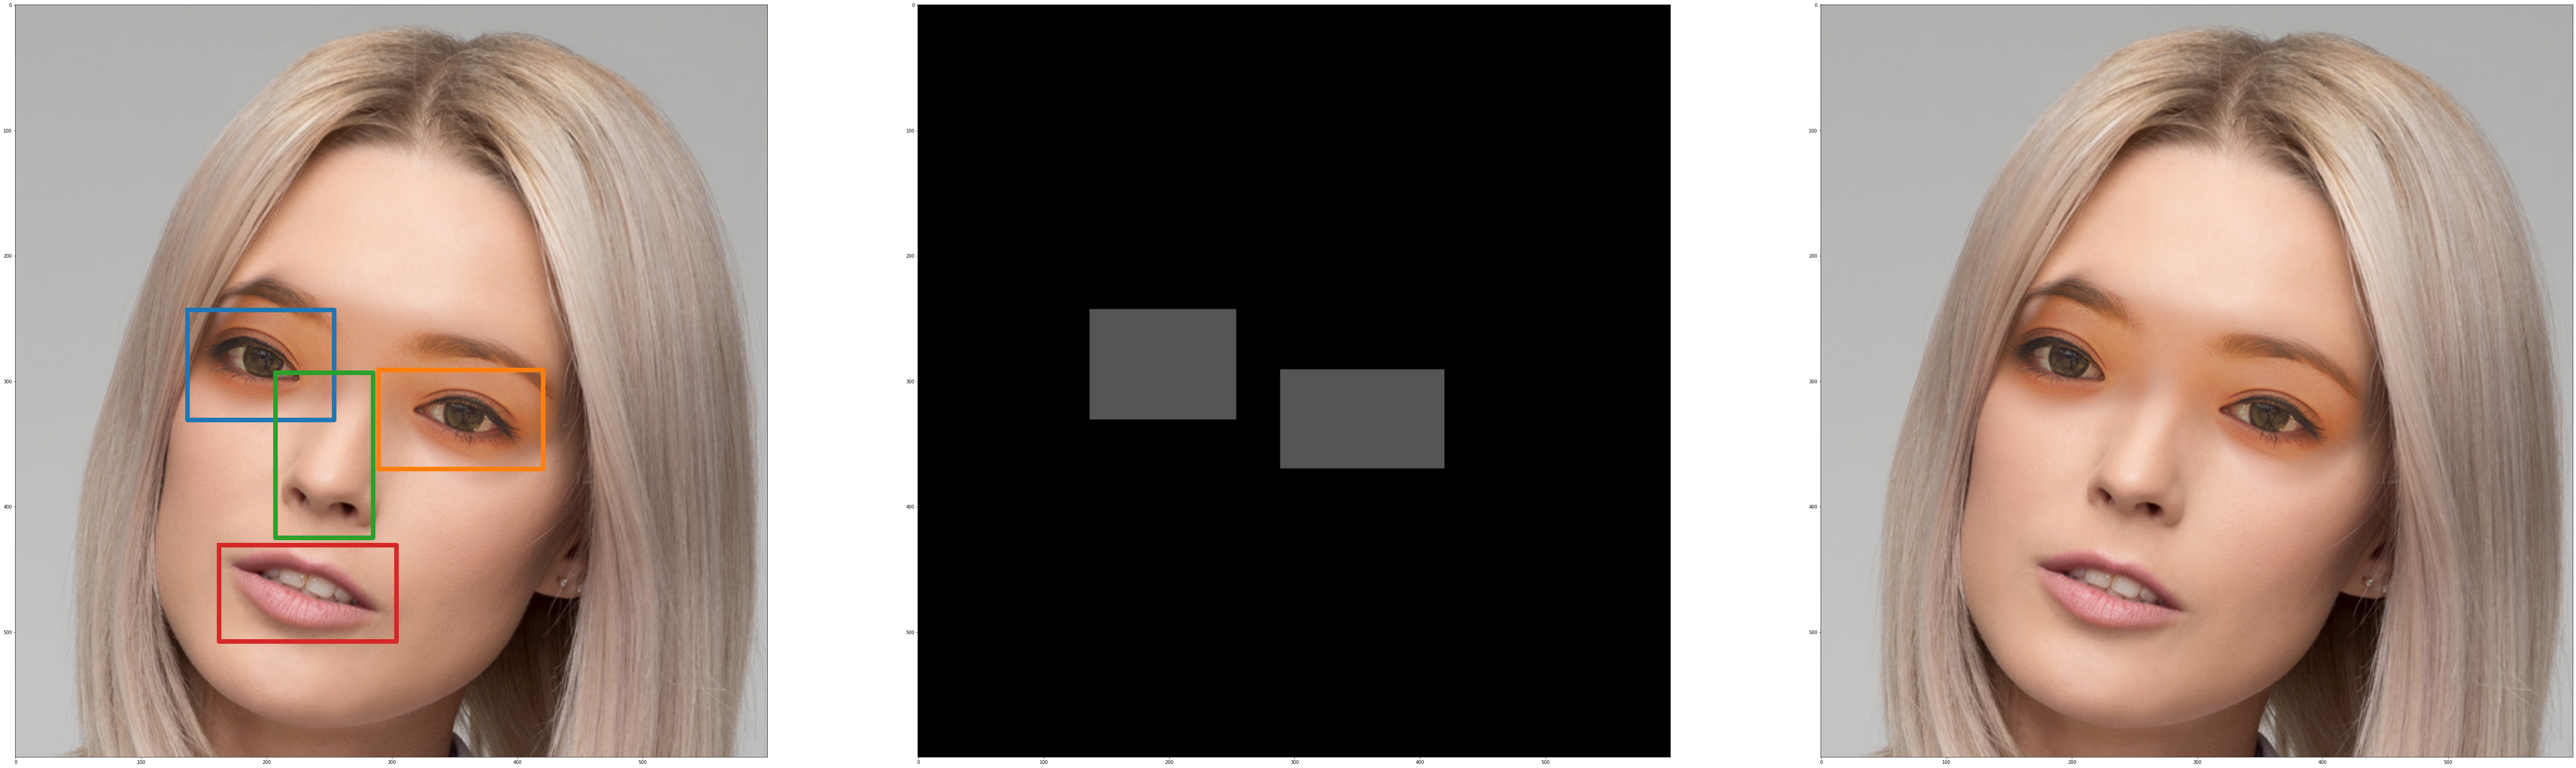

In [73]:
oneImgPipeline(123)